In [349]:
# Import libraries
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

df = pd.read_csv("data fix baru 50.csv")
df = shuffle(df, random_state=1)
df.head()

,no,playlist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
681,682,13,0.590,0.737,1,0.878575,1,0.0384,0.40400,0.000000,0.1080,0.877,0.614633,1
626,627,12,0.589,0.797,1,0.889288,1,0.1500,0.02890,0.000004,0.3830,0.232,0.473754,1
329,330,6,0.816,0.579,1,0.872461,1,0.0867,0.20300,0.000000,0.1270,0.430,0.555058,1
620,621,12,0.500,0.847,1,0.922302,1,0.0417,0.00125,0.000000,0.0875,0.716,0.582266,1
399,400,7,0.411,0.449,1,0.618288,0,0.0318,0.54800,0.609000,0.0814,0.579,0.665637,1


In [350]:
data = df.drop(columns=['no', 'playlist'])
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
681,0.590,0.737,1,0.878575,1,0.0384,0.40400,0.000000,0.1080,0.877,0.614633,1
626,0.589,0.797,1,0.889288,1,0.1500,0.02890,0.000004,0.3830,0.232,0.473754,1
329,0.816,0.579,1,0.872461,1,0.0867,0.20300,0.000000,0.1270,0.430,0.555058,1
620,0.500,0.847,1,0.922302,1,0.0417,0.00125,0.000000,0.0875,0.716,0.582266,1
399,0.411,0.449,1,0.618288,0,0.0318,0.54800,0.609000,0.0814,0.579,0.665637,1


In [351]:
target = df.playlist
target.head()

681    13
626    12
329     6
620    12
399     7
Name: playlist, dtype: int64

In [352]:
min_max_scaler = MinMaxScaler()

In [353]:
def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)

def getWeights(trainingSet, testInstance, trainingTarget, k, validities):
    distances = []
    length = len(testInstance)-1
    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x], length)
        weight = validities[x] * (1 / (dist + 0.5))
        distances.append((trainingTarget[x], dist, weight))
    distances.sort(key=operator.itemgetter(1))
    weights = []
    for x in range(k):
        weights.append([distances[x][0], distances[x][2]])
    return weights

def getNeighbors(trainingSet, testInstance, trainingTarget, k):
    distances = []
    length = len(testInstance)-1
    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x], length)
        distances.append((trainingTarget[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

def getResponse(weights):
    max = 0
    result = 0
    weightVotes = {}
    for x in range(len(weights)):
        response = weights[x][0]
        if response in weightVotes:
            weightVotes[response] += weights[x][1]
        else:
            weightVotes[response] = weights[x][1]
    for key, value in weightVotes.items():
        if(value > max):
            result = key
            max = value
    return result

def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0

def getValidities(trainingSet, trainingTarget, h):
    validities = []
    for i in range(len(trainingSet)):
        X = np.delete(trainingSet, i, 0)
        neighbors = getNeighbors(X, trainingSet[i], trainingTarget, h)
        s = 0
        for y in range(len(neighbors)):
            if(trainingTarget[i] == neighbors[y]):
                s += 1
        validities.append(s/h)
    return validities

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

> 35 predicted = 5, actual = 9
> 36 predicted = 1, actual = 1
> 37 predicted = 0, actual = 13
> 38 predicted = 1, actual = 1
> 39 predicted = 13, actual = 13
> 40 predicted = 5, actual = 5
> 41 predicted = 5, actual = 5
> 42 predicted = 12, actual = 8
> 43 predicted = 5, actual = 9
> 44 predicted = 9, actual = 4
> 45 predicted = 4, actual = 10
> 46 predicted = 5, actual = 5
> 47 predicted = 5, actual = 11
> 48 predicted = 4, actual = 7
> 49 predicted = 7, actual = 7
> 50 predicted = 2, actual = 10
> 51 predicted = 0, actual = 1
> 52 predicted = 1, actual = 1
> 53 predicted = 7, actual = 7
> 54 predicted = 3, actual = 3
> 55 predicted = 11, actual = 10
> 56 predicted = 12, actual = 12
> 57 predicted = 3, actual = 2
> 58 predicted = 5, actual = 9
> 59 predicted = 2, actual = 2
> 60 predicted = 12, actual = 5
> 61 predicted = 0, actual = 13
> 62 predicted = 4, actual = 0
> 63 predicted = 4, actual = 10
> 64 predicted = 9, actual = 11
> 65 predicted = 5, actual = 13
> 66 predicted = 12, ac

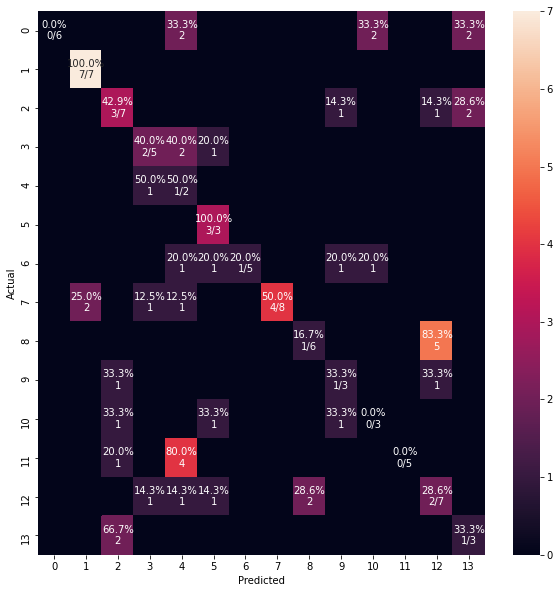

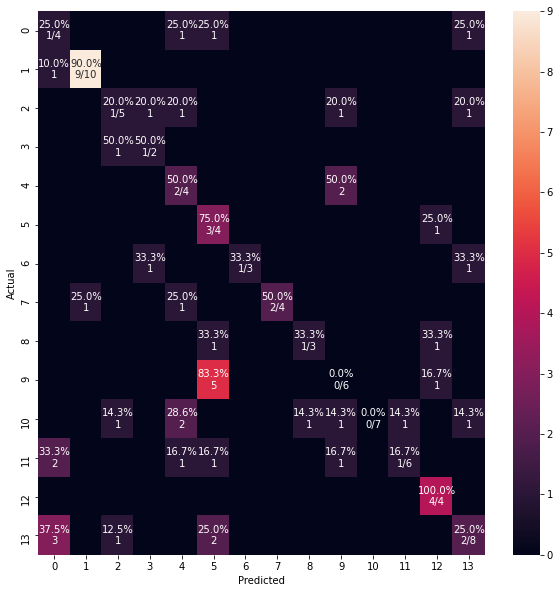

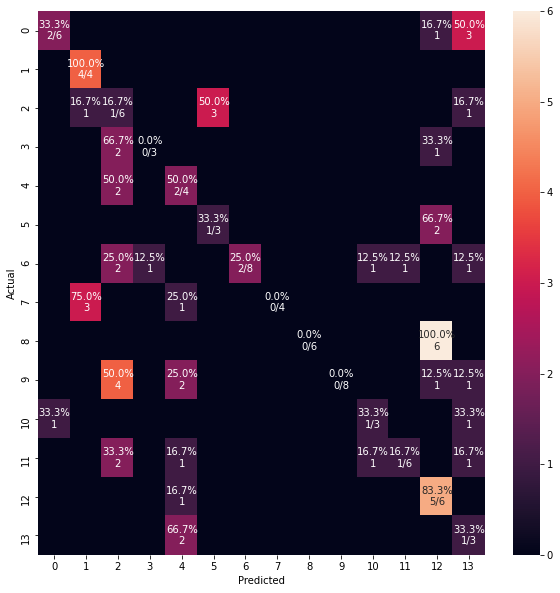

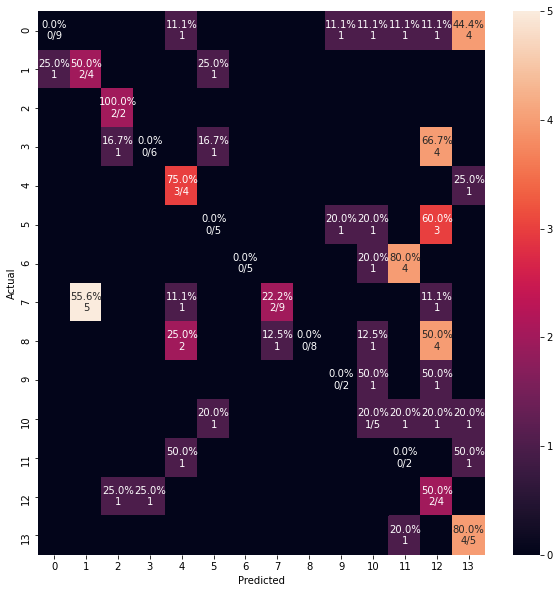

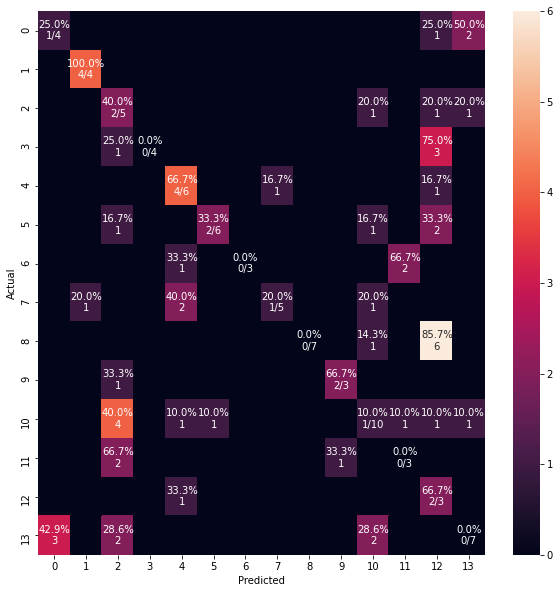

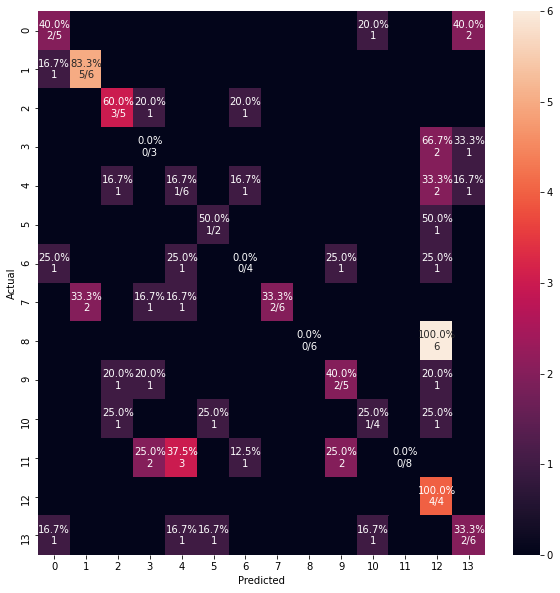

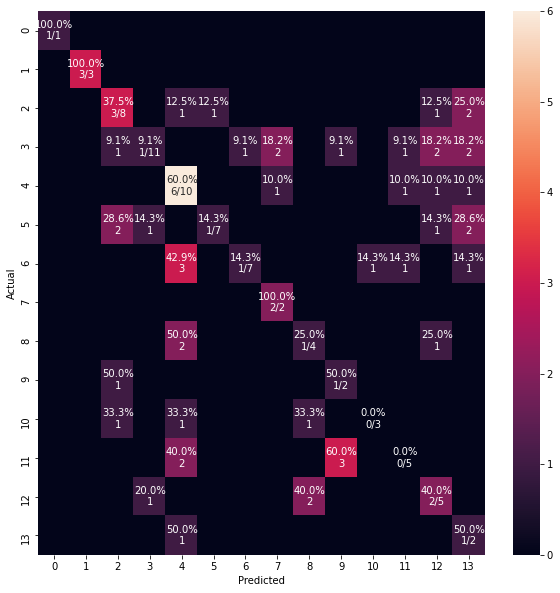

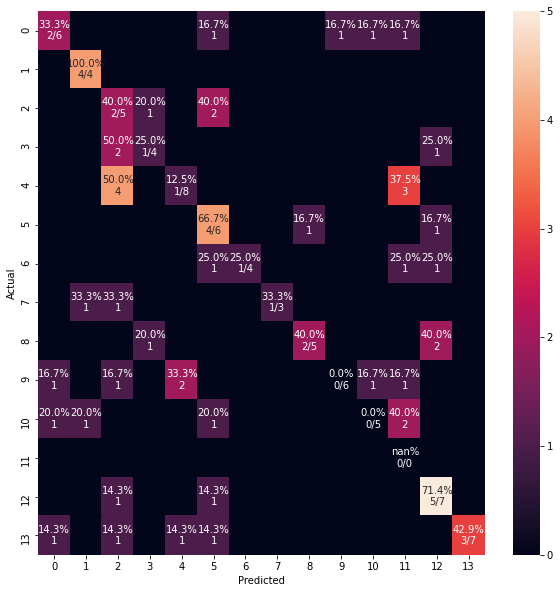

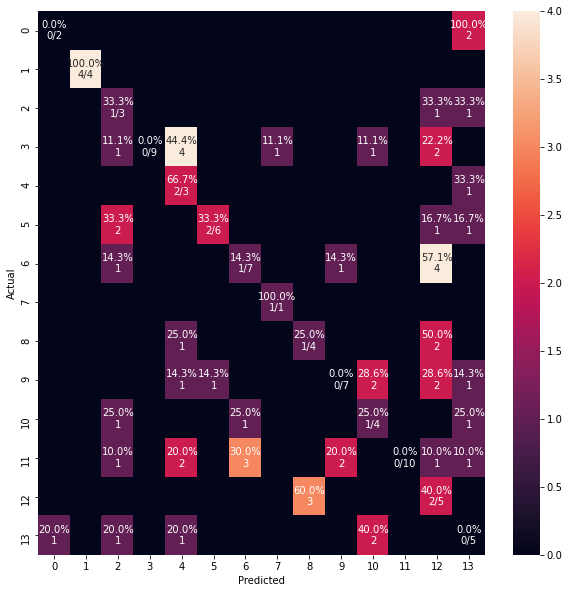

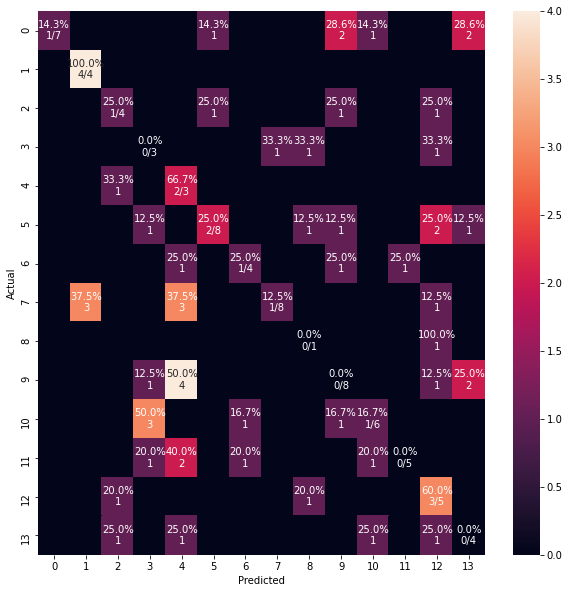

In [354]:
X = data.values
y = target.values
kf = KFold(n_splits=10)
# pca = PCA(n_components=2)
k = 56
h = 56

# KNN
fold = 0
accuracy_total = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train_scale = min_max_scaler.fit_transform(X_train)
    X_test_scale = min_max_scaler.transform(X_test)
    
#     pca.fit(X_train_scale)
#     X_train_pca = pca.fit_transform(X_train_scale)
#     X_test_pca = pca.fit_transform(X_test_scale)
    
#     index = np.hstack((train_index, test_index))
#     index = np.reshape(index, (len(index), 1))
#     X_pca = np.vstack((X_train_pca, X_test_pca))
#     Y_pca = np.hstack((y_train, y_test))
#     Y_pca = np.reshape(Y_pca, (len(Y_pca), 1))
#     data_pca = np.hstack((index, X_pca, Y_pca))
    
    predictions=[]
    
    fold += 1
#     np.savetxt('Klasifikasi Data/KNN MKNN tanpa PCA/Data PCA MKNN Fold ' + str(fold) + '.csv', data_pca, delimiter=",")
    print('KFold ' + str(fold))
    print('======================================')
    
    validities = getValidities(X_train_scale, y_train, h)
    
    for i in range(len(X_test_scale)):
        weights = getWeights(X_train_scale, X_test_scale[i], y_train, k, validities)
        result = getResponse(weights)
        predictions.append(result)
        
        print('> ' + str(i + 1) + ' predicted = ' + repr(result) + ', actual = ' + repr(y_test[i]))
        
    accuracy = accuracy_score(y_test, predictions)
    accuracy_total += accuracy
    cm_analysis(y_test, predictions, target.unique().sort(), ymap=None, figsize=(10,10))
    plt.savefig('Klasifikasi Data/Gambar Confussion Matrix tanpa PCA/Confussion Matrix MKNN Fold ' + str(fold) + '.jpg')
    
    print('---------------------------------------')
    print('KFold ' + str(fold) + ', Accuracy ' + str(accuracy))
    print('\n')
   # print('Klasifikasi Data/KNN MKNN tanpa PCA/Data PCA MKNN Fold ' + str(fold) + '.csv')

print('======================================')
print('Average Accuracy = ' + str(accuracy_total/fold))
print('======================================')
print('\n')